In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import imageio
import os
import glob
from scipy.integrate import odeint

In [2]:
def sir(f, t, beta, r, N):
    '''
    Generates SIR model.
    
    Arguments:
        f - S, I and R values
        t - time
        beta - transmission rate
        r - recovery rate
    '''
    
    S, I, R = f
    dS = -beta * S * I
    dI = beta * S * I - r * I
    dR = r * I

    return [dS, dI, dR]

def si(f, t, beta, N):
    '''
    Generates SI model.
    
    Arguments:
        f - S, I and R values
        t - time
        beta - transmission rate
    '''
    
    S, I = f
    dS = -beta * S * I 
    dI = beta * S * I 

    return [dS, dI]

def R0(beta, r):
    '''
    Calculates basic reproductive ratio.
    
    Arguments:
        beta - transmission rate
        r - recovery rate
    '''
    R_0 = beta * N / r
    return np.round(R_0, 4)

### Parameters used in most of the simulations

In [11]:
N = 100
t = np.linspace(0, 500, 1000)

bs = [0.1, 0.5, 10]
betas = [i/N for i in bs]
rs = [0.01, 0.8]

newBs = np.linspace(0.1, 1, 100)
newBetas = [1/N for i in newBs]
newRs = np.linspace(0.1, 1, 100)

### Generating SIR model for different sets of parameters and checking if there is an epidemic

### From literature I found that usually there is an epidemic when the maximum number of infected is more or equal 10% of population

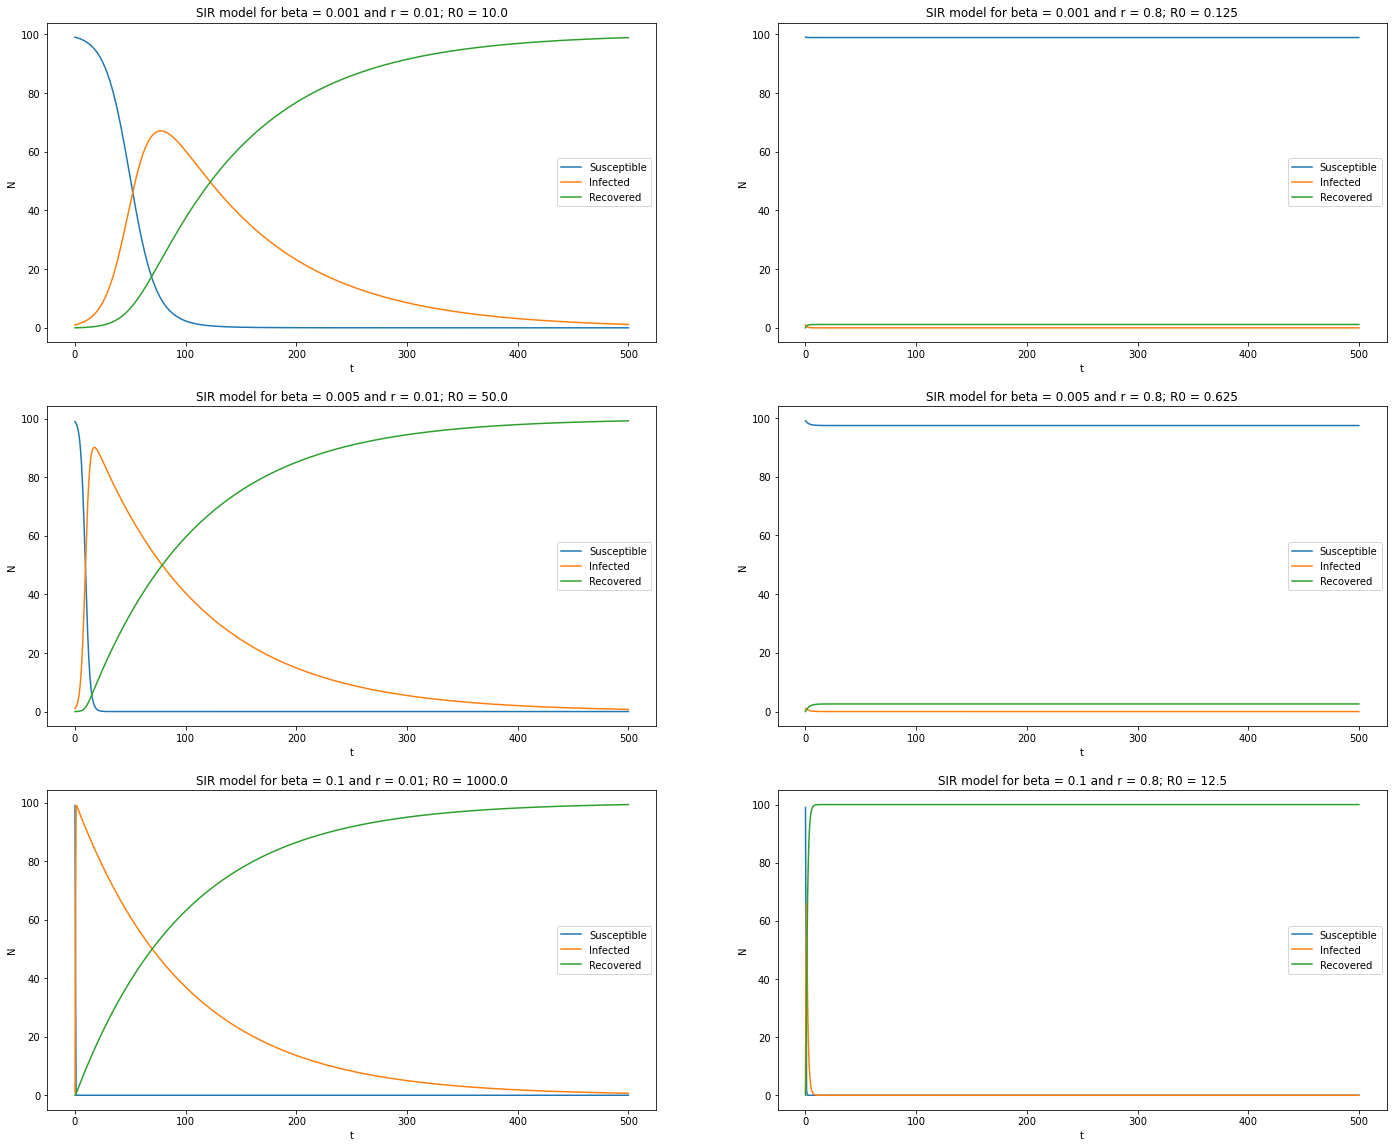

In [12]:
IC = [N - 1, 1, 0] # [susceptible, infected, recovered]

R_0s = ['R0']
bs = ['beta']
rs2 = ['r']
res_threshold = ['result from plot']

fig, axes = plt.subplots(len(betas), len(rs), figsize=(24, 20))

for i, b in enumerate(betas):
    for j, r in enumerate(rs):
        SIR = odeint(sir, IC, t, args = (b, r, N))
        S, I, R = SIR.T
        R_0 = R0(b, r)
        
        ax = axes[i, j]
        ax.plot(t, S, label='Susceptible')
        ax.plot(t, I, label='Infected')
        ax.plot(t, R, label='Recovered')
        
        ax.set_xlabel('t')
        ax.set_ylabel('N')
        ax.set_title(f'SIR model for beta = {b} and r = {r}; R0 = {R_0}')

        ax.legend()

        R_0s.append(R_0)
        bs.append(b)
        rs2.append(r)
        
        # checking if there is an epidemic using commonly used threshold that is a fraction of the total population,
        # in this case set to 0.1 (10%) of the population
        
        max_infected = np.max(I)
        if max_infected > 0.1 * N:
            res_threshold.append('epidemic')
        else:
            res_threshold.append('no epidemic')

plt.show()

In [13]:
res = ['result from R0']

for i in range(1, len(R_0s)):
    if R_0s[i] > 1:
        res.append('epidemic')
    else:
        res.append('no epidemic')
        
tbl = zip(bs, rs2, R_0s, res, res_threshold)

for i in tbl:
    print("{:<10} {:<10} {:<10} {:<18} {:<10}".format(*i))

beta       r          R0         result from R0     result from plot
0.001      0.01       10.0       epidemic           epidemic  
0.001      0.8        0.125      no epidemic        no epidemic
0.005      0.01       50.0       epidemic           epidemic  
0.005      0.8        0.625      no epidemic        no epidemic
0.1        0.01       1000.0     epidemic           epidemic  
0.1        0.8        12.5       epidemic           epidemic  


### Phase portraits for different betas - do not seem to be good

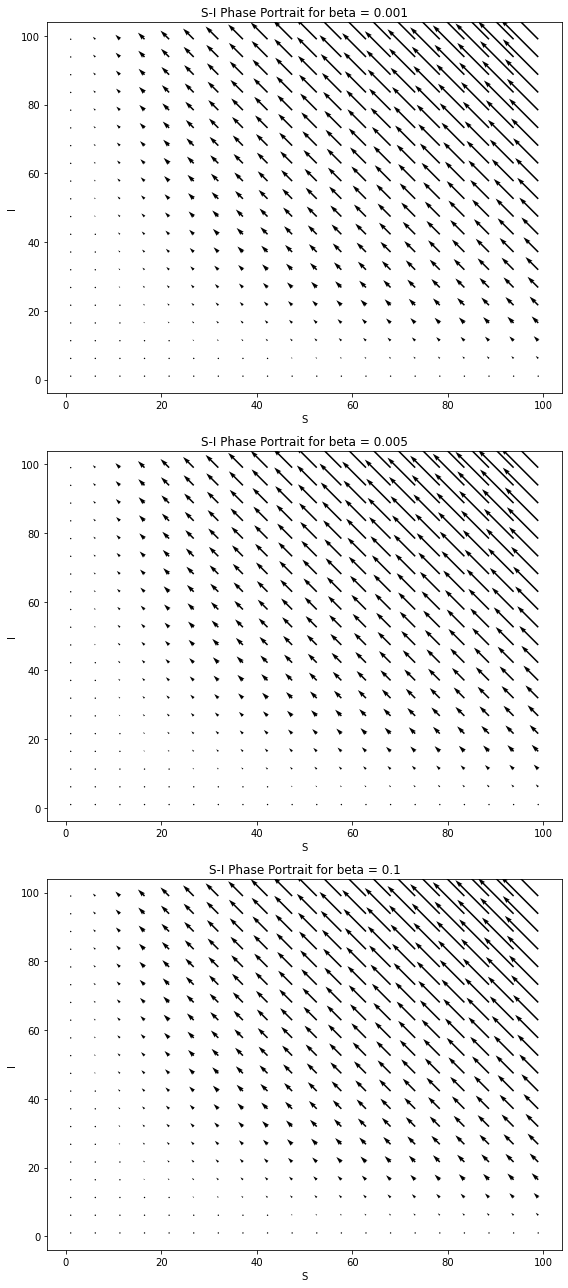

In [14]:
fig, axes = plt.subplots(len(betas), 1, figsize=(8, 6*len(betas)))

for i, beta in enumerate(betas):
    s0 = np.linspace(1, N-1, 20)
    i0 = np.linspace(1, N-1, 20)
    
    S0, I0 = np.meshgrid(s0, i0)
    
    u, v = np.zeros(S0.shape), np.zeros(I0.shape)
    n1, n2 = S0.shape
    
    for j in range(n1):
        for k in range(n2):
            s = S0[j, k]
            ii = I0[j, k]
            
            #SI = odeint(si, [s, ii], t, args=(beta, N))
            #S, I = SI.T
            
            #dS, dI = si([s, ii], 0, beta, N)
            dS = -beta * s * ii
            dI = beta * s * ii
            u[j, k] = dS
            v[j, k] = dI
    
    ax = axes[i]
    ax.quiver(S0, I0, u, v)
    
    ax.set_xlabel('S')
    ax.set_ylabel('I')
    ax.set_title(f'S-I Phase Portrait for beta = {beta}')

plt.tight_layout()
plt.show()

###  Plotting the total number of infections as a function of R0. I used new sets of parameters

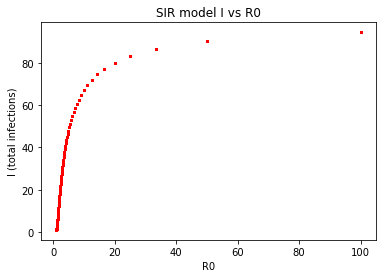

In [16]:
newBs = np.linspace(0.01, 1, 100)
newBetas = [1/N for i in newBs]
newRs = np.linspace(0.01, 1, 100)

IC = [N - 1, 1, 0] # [susceptible, infected, recovered]

totalI = []
R0Vals = []

for b in newBetas:
    for r in newRs:
        SIR = odeint(sir, IC, t, args = (b, r, N))
        S, I, R = SIR.T
        totalI.append(np.max(I))
        R0Vals.append(R0(b, r))
        
plt.scatter(R0Vals, totalI, s = 1, c = 'red')
plt.xlabel('R0')
plt.ylabel('I (total infections)')
plt.title('SIR model I vs R0')
plt.show()

### SIR model for 2D lattice. For other graphs the code will be below it

In [56]:
def SIRonLatticeInfectedFrac(xsize=10, ysize=10, ps=[0.4], iterations=50, runs=100):
    G = nx.grid_2d_graph(xsize, ysize)

#     for node in G.nodes:
#         G.nodes[node]['state'] = 'S'

#     init = random.choice(list(G.nodes))
#     G.nodes[init]['state'] = 'I'

    infectedFrac = np.zeros((runs, iterations + 1, len(ps)))

    for run in range(runs):
        for p_idx, p in enumerate(ps):
            init = random.choice(list(G.nodes))
            for node in G.nodes:
                G.nodes[node]['state'] = 'S'
            G.nodes[init]['state'] = 'I'

            infectedFrac[run][0][p_idx] = 1 / (xsize * ysize)

            for t in range(1, iterations + 1):
                infectedNodes = []
                for node in G.nodes:
                    if G.nodes[node]['state'] == 'I':
                        infectedNodes.append(node)

                for node in infectedNodes:
                    neighbors = list(G.neighbors(node))
                    susceptibleNeighbors = []
                    for n in neighbors:
                        if G.nodes[n]['state'] == 'S':
                            susceptibleNeighbors.append(n)

                    for neighbor in susceptibleNeighbors:
                        q = random.random()
                        if q < p:
                            G.nodes[neighbor]['state'] = 'I'

                    G.nodes[node]['state'] = 'R'

                numInfected = len([node for node in G.nodes if G.nodes[node]['state'] == 'I'])
                infectedFracOneRun = numInfected / (xsize * ysize)
                infectedFrac[run][t][p_idx] = infectedFracOneRun

    return infectedFrac

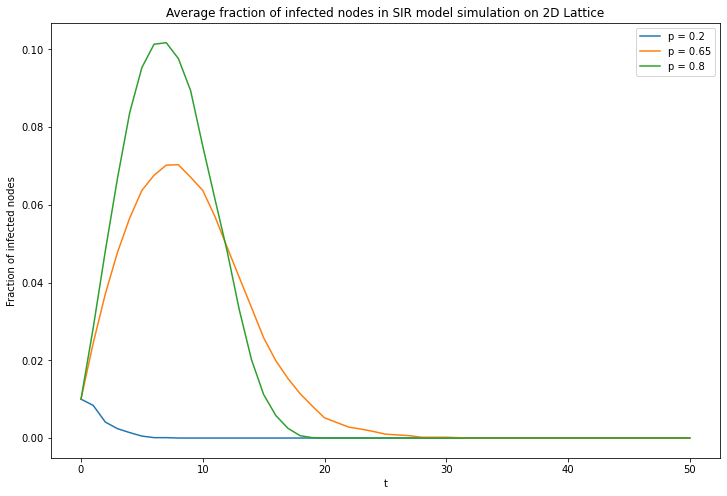

In [57]:
ps = [0.2, 0.65, 0.8]

infectedFractions = SIRonLatticeInfectedFrac(ps=ps)
avgInfectedFractions = np.mean(infectedFractions, axis=0)

plt.figure(figsize=(12, 8))

for p_idx, p in enumerate(ps):
    plt.plot(range(51), avgInfectedFractions[:, p_idx], label = f'p = {p}')

plt.xlabel('t')
plt.ylabel('Fraction of infected nodes')
plt.title('Average fraction of infected nodes in SIR model simulation on 2D Lattice')
plt.legend()
plt.show()        

In [58]:
def SIRonLatticeDynamics(xsize=10, ysize=10, ps=[0.4], iterations=50, runs=100):
    G = nx.grid_2d_graph(xsize, ysize)

    #for node in G.nodes:
    #    G.nodes[node]['state'] = 'S'

    infectedFrac = np.zeros((runs, len(ps)))
    timeToClear = np.zeros((runs, len(ps)))
    timeToMaxInfected = np.zeros((runs, len(ps)))

    for run in range(runs):
        for p_idx, p in enumerate(ps):

            init = random.choice(list(G.nodes))
            for node in G.nodes:
                G.nodes[node]['state'] = 'S'
            G.nodes[init]['state'] = 'I'

            infectedCount = [1]
            maxInfectedCount = 1
            timeOfMaxInfected = 0

            for t in range(1, iterations + 1):
                infectedNodes = [node for node in G.nodes if G.nodes[node]['state'] == 'I']

                for node in infectedNodes:
                    neighbors = list(G.neighbors(node))
                    susceptibleNeighbors = [n for n in neighbors if G.nodes[n]['state'] == 'S']

                    for neighbor in susceptibleNeighbors:
                        q = random.random()
                        if q < p:
                            G.nodes[neighbor]['state'] = 'I'

                    G.nodes[node]['state'] = 'R'

                numInfected = len([node for node in G.nodes if G.nodes[node]['state'] == 'I'])

                if numInfected == 0 and 'I' not in [G.nodes[node]['state'] for node in G.nodes]:
                    timeToClear[run][p_idx] = t
                    timeToMaxInfected[run][p_idx] = timeOfMaxInfected
                    break

                infectedCount.append(numInfected)
                if numInfected > maxInfectedCount:
                    maxInfectedCount = numInfected
                    timeOfMaxInfected = t

                infectedFraction = numInfected / (xsize * ysize)
                infectedFrac[run][p_idx] = infectedFraction

    return infectedFrac, timeToClear, timeToMaxInfected

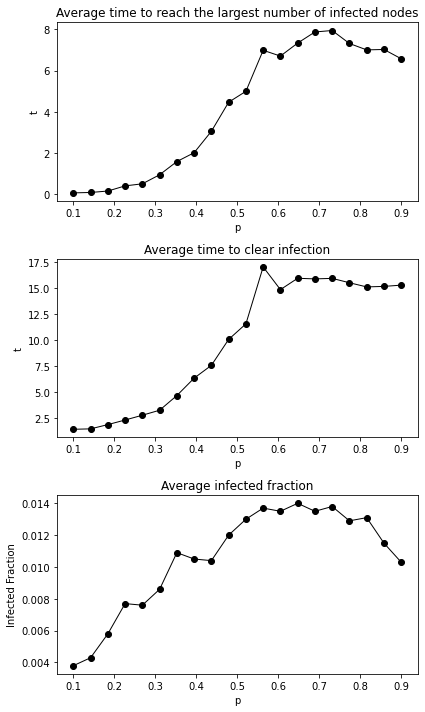

In [59]:
ps = np.linspace(0.1, 0.9, 20)

infectedFrac, timeToClear, timeToMaxInfected = SIRonLatticeDynamics(ps=ps)
avgTimeToClear = np.mean(timeToClear, axis=0)
avgTimeToMaxInfected = np.mean(timeToMaxInfected, axis=0)
avgInfectedFrac = np.mean(infectedFrac, axis=0)

plt.figure(figsize=(6, 10))

plt.subplot(3, 1, 1)
plt.plot(ps, avgTimeToMaxInfected, linewidth=1, c='black', marker='o')
plt.xlabel('p')
plt.ylabel('t')
plt.title('Average time to reach the largest number of infected nodes')

plt.subplot(3, 1, 2)
plt.plot(ps, avgTimeToClear, linewidth=1, c='black', marker='o')
plt.xlabel('p')
plt.ylabel('t')
plt.title('Average time to clear infection')

plt.subplot(3, 1, 3)
plt.plot(ps, avgInfectedFrac, linewidth=1, c='black', marker='o')
plt.xlabel('p')
plt.ylabel('Infected Fraction')
plt.title('Average infected fraction')

plt.tight_layout()
plt.show()

In [69]:
def SIRonLatticeGenerateMovie(xsize=10, ysize=10, p=0.8, iterations=100):
    if not os.path.exists('2DLatticeMovie'):
        os.makedirs('2DLatticeMovie')
        
    files = glob.glob(os.path.join('2DLatticeMovie', '*')) # get access to all files in a folder
    for f in files:
        os.remove(f)
    
    colorMap = {'S': 'blue', 'I': 'red', 'R': 'green'}
    
    G = nx.grid_2d_graph(xsize, ysize)

    for node in G.nodes:
        G.nodes[node]['state'] = 'S'

    init = random.choice(list(G.nodes))
    G.nodes[init]['state'] = 'I'

    states = nx.get_node_attributes(G, 'state')
    
    plt.figure(figsize=(6, 6))
    pos = {node: (node[1], node[0]) for node in G.nodes}
    nx.draw(G, pos = pos, node_color = [colorMap[states[node]] for node in G.nodes],
            node_size = 200, with_labels = False)
    
    plt.savefig(os.path.join('2DLatticeMovie', f'img_{0}.png'))
    plt.close()
    
    for t in range(1, iterations + 1):
        infectedNodes = [node for node in G.nodes if G.nodes[node]['state'] == 'I']

        for node in infectedNodes:
            neighbors = list(G.neighbors(node))
            susceptibleNeighbors = [n for n in neighbors if G.nodes[n]['state'] == 'S']

            for neighbor in susceptibleNeighbors:
                q = random.random()
                if q < p:
                    G.nodes[neighbor]['state'] = 'I'

            G.nodes[node]['state'] = 'R'

        states = nx.get_node_attributes(G, 'state')
            
        plt.figure(figsize=(6, 6))
        pos = {node: (node[1], node[0]) for node in G.nodes}
        nx.draw(G, pos = pos, node_color = [colorMap[states[node]] for node in G.nodes],
                node_size = 200, with_labels = False)

        plt.savefig(os.path.join('2DLatticeMovie', f'img_{t}.png'))
        plt.close()
        
    with imageio.get_writer('2DLattice.mp4', mode = 'I', fps = 5) as w:
        for i in range(iterations + 1):
            file = os.path.join('2DLatticeMovie', f'img_{i}.png')
            img = imageio.imread(file)
            w.append_data(img)

In [70]:
SIRonLatticeGenerateMovie(xsize = 10, ysize = 10, p = 0.65, iterations = 50)

### SIR model on graphs

In [60]:
def SIRonGraphInfectedFrac(graphType, N = 100, ps = [0.4], iterations = 50, runs = 100, m = 5, k = 5):
    
    infectedFrac = np.zeros((runs, iterations + 1, len(ps)))
    
    for p_idx, p in enumerate(ps):
        if graphType == "barabasiAlbert":
            G = nx.barabasi_albert_graph(N, m)
        elif graphType == "wattsStrogatz":
            G = nx.watts_strogatz_graph(N, k, p)
        elif graphType == "random":
            G = nx.erdos_renyi_graph(N, p)

        for run in range(runs):   
            init = random.choice(list(G.nodes))
            
            for node in G.nodes:
                G.nodes[node]['state'] = 'S'
            G.nodes[init]['state'] = 'I'

            infectedFrac[run][0][p_idx] = 1 / N

            for t in range(1, iterations + 1):
                infectedNodes = []
                for node in G.nodes:
                    if G.nodes[node]['state'] == 'I':
                        infectedNodes.append(node)

                for node in infectedNodes:
                    neighbors = list(G.neighbors(node))
                    susceptibleNeighbors = []
                    for n in neighbors:
                        if G.nodes[n]['state'] == 'S':
                            susceptibleNeighbors.append(n)

                    for neighbor in susceptibleNeighbors:
                        q = random.random()
                        if q < p:
                            G.nodes[neighbor]['state'] = 'I'

                    G.nodes[node]['state'] = 'R'

                numInfected = len([node for node in G.nodes if G.nodes[node]['state'] == 'I'])
                infectedFracOneRun = numInfected / N
                infectedFrac[run][t][p_idx] = infectedFracOneRun

    return infectedFrac

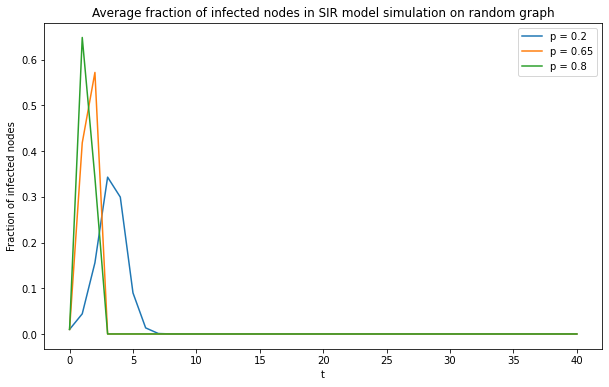

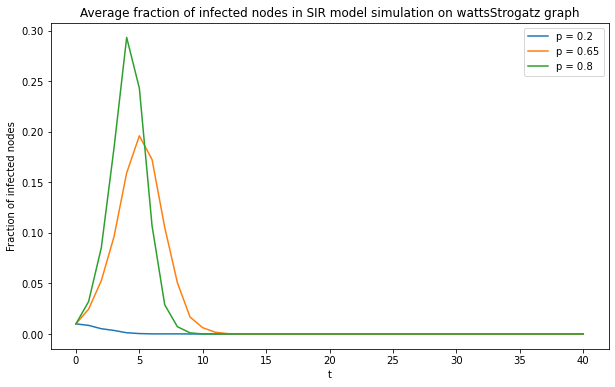

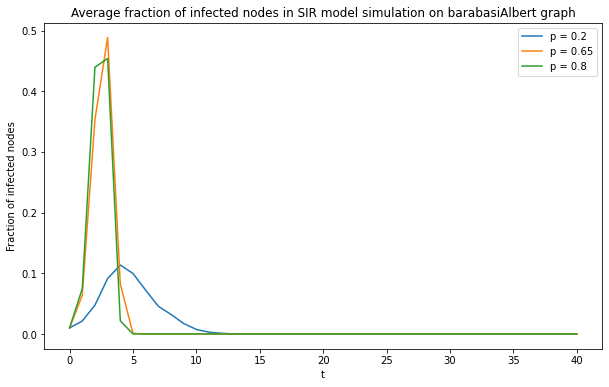

In [61]:
ps = [0.2, 0.65, 0.8]
iterations = 40

for graph in ['random', 'wattsStrogatz', 'barabasiAlbert']:
    plt.figure(figsize=(10, 6))
    infectedFractions = SIRonGraphInfectedFrac(graph, ps = ps, iterations = iterations)
    avgInfectedFractions = np.mean(infectedFractions, axis = 0)

    for p_idx, p in enumerate(ps):
        plt.plot(range(iterations + 1), avgInfectedFractions[:, p_idx], label = f'p = {p}')

    plt.xlabel('t')
    plt.ylabel('Fraction of infected nodes')
    plt.title(f'Average fraction of infected nodes in SIR model simulation on {graph} graph')
    plt.legend()
    plt.show()        

In [62]:
def SIRonGraphDynamics(graphType, N = 100, ps = [0.4], iterations = 50, runs = 100, m = 5, k = 5):
    
    infectedFrac = np.zeros((runs, iterations + 1, len(ps)))
    
    infectedFrac = np.zeros((runs, len(ps)))
    timeToClear = np.zeros((runs, len(ps)))
    timeToMaxInfected = np.zeros((runs, len(ps)))
    
    for p_idx, p in enumerate(ps):
        if graphType == "barabasiAlbert":
            G = nx.barabasi_albert_graph(N, m)
        elif graphType == "wattsStrogatz":
            G = nx.watts_strogatz_graph(N, k, p)
        elif graphType == "random":
            G = nx.erdos_renyi_graph(N, p)

        for run in range(runs):
            
            init = random.choice(list(G.nodes))
                
            for node in G.nodes:
                G.nodes[node]['state'] = 'S'

            G.nodes[init]['state'] = 'I'

            infectedCount = [1]
            maxInfectedCount = 1
            timeOfMaxInfected = 0

            for t in range(1, iterations + 1):
                infectedNodes = [node for node in G.nodes if G.nodes[node]['state'] == 'I']

                for node in infectedNodes:
                    neighbors = list(G.neighbors(node))
                    susceptibleNeighbors = [n for n in neighbors if G.nodes[n]['state'] == 'S']

                    for neighbor in susceptibleNeighbors:
                        q = random.random()
                        if q < p:
                            G.nodes[neighbor]['state'] = 'I'

                    G.nodes[node]['state'] = 'R'

                numInfected = len([node for node in G.nodes if G.nodes[node]['state'] == 'I'])

                if numInfected == 0 and 'I' not in [G.nodes[node]['state'] for node in G.nodes]:
                    timeToClear[run][p_idx] = t
                    timeToMaxInfected[run][p_idx] = timeOfMaxInfected
                    break

                infectedCount.append(numInfected)
                if numInfected > maxInfectedCount:
                    maxInfectedCount = numInfected
                    timeOfMaxInfected = t

                infectedFraction = numInfected / N
                infectedFrac[run][p_idx] = infectedFraction

    return infectedFrac, timeToClear, timeToMaxInfected

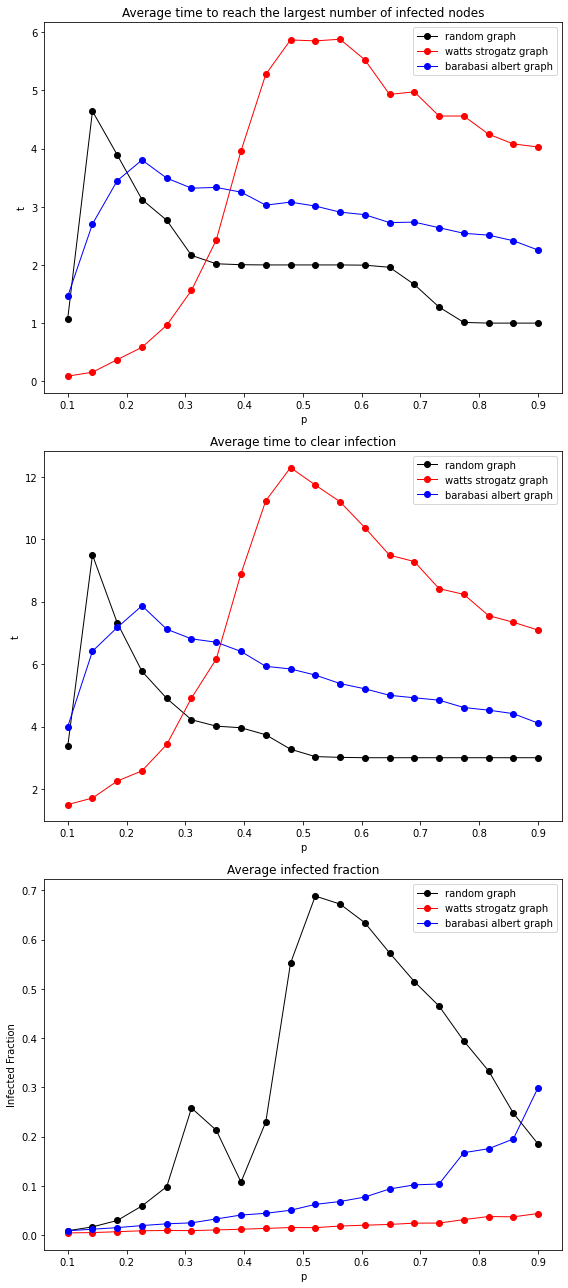

In [63]:
ps = np.linspace(0.1, 0.9, 20)
iterations = 100

infectedFrac = []
timeToClear = []
timeToMaxInfected = []
avgTimeToClear = []
avgTimeToMaxInfected = []
avgInfectedFrac = []

for graph in ['random', 'wattsStrogatz', 'barabasiAlbert']:
    infFrac, clear, maxInfected = SIRonGraphDynamics(graph, ps = ps, iterations = iterations, runs = 250)
    avgClear = np.mean(clear, axis=0)
    avgMaxInfected = np.mean(maxInfected, axis=0)
    avgInfFrac = np.mean(infFrac, axis=0)
    
    infectedFrac.append(infFrac)
    timeToClear.append(clear)
    timeToMaxInfected.append(maxInfected)
    avgTimeToClear.append(avgClear)
    avgTimeToMaxInfected.append(avgMaxInfected)
    avgInfectedFrac.append(avgInfFrac)

plt.figure(figsize=(8, 18))

plt.subplot(3, 1, 1)
plt.plot(ps, avgTimeToMaxInfected[0], linewidth=1, c='black', marker='o', label = 'random graph')
plt.plot(ps, avgTimeToMaxInfected[1], linewidth=1, c='red', marker='o', label = 'watts strogatz graph')
plt.plot(ps, avgTimeToMaxInfected[2], linewidth=1, c='blue', marker='o', label = 'barabasi albert graph')
plt.xlabel('p')
plt.ylabel('t')
plt.title('Average time to reach the largest number of infected nodes')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(ps, avgTimeToClear[0], linewidth=1, c='black', marker='o', label = 'random graph')
plt.plot(ps, avgTimeToClear[1], linewidth=1, c='red', marker='o', label = 'watts strogatz graph')
plt.plot(ps, avgTimeToClear[2], linewidth=1, c='blue', marker='o', label = 'barabasi albert graph')
plt.xlabel('p')
plt.ylabel('t')
plt.title(f'Average time to clear infection')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(ps, avgInfectedFrac[0], linewidth=1, c='black', marker='o', label = 'random graph')
plt.plot(ps, avgInfectedFrac[1], linewidth=1, c='red', marker='o', label = 'watts strogatz graph')
plt.plot(ps, avgInfectedFrac[2], linewidth=1, c='blue', marker='o', label = 'barabasi albert graph')
plt.xlabel('p')
plt.ylabel('Infected Fraction')
plt.title(f'Average infected fraction')
plt.legend()

plt.tight_layout()
plt.show()

In [90]:
def SIRonGraphGenerateMovie(graphType, N = 30, p = 0.4, iterations = 100, m = 5, k = 5):
    if not os.path.exists('randomGraphMovie'):
        os.makedirs('randomGraphMovie')
    if not os.path.exists('wattsStrogatzGraphMovie'):
        os.makedirs('wattsStrogatzGraphMovie')
    if not os.path.exists('barabasiAlbertGraphMovie'):
        os.makedirs('barabasiAlbertGraphMovie')
        
    if graphType == 'random':
        files = glob.glob(os.path.join('randomGraphMovie', '*')) # get access to all files in a folder
        path = 'randomGraphMovie'
    elif graphType == 'barabasiAlbert':
        files = glob.glob(os.path.join('barabasiAlbertGraphMovie', '*')) # get access to all files in a folder
        path = 'barabasiAlbertGraphMovie'
    elif graphType == 'wattsStrogatz':
        files = glob.glob(os.path.join('wattsStrogatzGraphMovie', '*')) # get access to all files in a folder
        path = 'wattsStrogatzGraphMovie'
    
    for f in files:
            os.remove(f)
    
    colorMap = {'S': 'blue', 'I': 'red', 'R': 'green'}
    
    if graphType == "barabasiAlbert":
        G = nx.barabasi_albert_graph(N, m)
    elif graphType == "wattsStrogatz":
        G = nx.watts_strogatz_graph(N, k, p)
    elif graphType == "random":
        G = nx.erdos_renyi_graph(N, p)

    for node in G.nodes:
        G.nodes[node]['state'] = 'S'

    init = random.choice(list(G.nodes))
    G.nodes[init]['state'] = 'I'

    states = nx.get_node_attributes(G, 'state')
    
    plt.figure(figsize=(6, 6), dpi = 180)
    pos = pos = nx.spring_layout(G, seed = 55)
    nx.draw(G, pos = pos, node_color = [colorMap[states[node]] for node in G.nodes],
            node_size = 100, with_labels = False)
    
    plt.savefig(os.path.join(path, f'img_{0}.png'))
    plt.close()
    
    for t in range(1, iterations + 1):
        infectedNodes = [node for node in G.nodes if G.nodes[node]['state'] == 'I']

        for node in infectedNodes:
            neighbors = list(G.neighbors(node))
            susceptibleNeighbors = [n for n in neighbors if G.nodes[n]['state'] == 'S']

            for neighbor in susceptibleNeighbors:
                q = random.random()
                if q < p:
                    G.nodes[neighbor]['state'] = 'I'

            G.nodes[node]['state'] = 'R'

        states = nx.get_node_attributes(G, 'state')
            
        plt.figure(figsize=(6, 6), dpi = 180)
        pos = pos = nx.spring_layout(G, seed = 55)
        nx.draw(G, pos = pos, node_color = [colorMap[states[node]] for node in G.nodes],
                node_size = 100, with_labels = False)

        plt.savefig(os.path.join(path, f'img_{t}.png'))
        plt.close()
        
    with imageio.get_writer(f'{path}_movie.mp4', mode = 'I', fps = 2) as w:
        for i in range(iterations + 1):
            file = os.path.join(path, f'img_{i}.png')
            img = imageio.imread(file)
            w.append_data(img)

In [94]:
SIRonGraphGenerateMovie('random', N = 30, p = 0.55, iterations = 40)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1080, 1080) to (1088, 1088) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [95]:
SIRonGraphGenerateMovie('barabasiAlbert', N = 30, p = 0.6, iterations = 40)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1080, 1080) to (1088, 1088) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [97]:
SIRonGraphGenerateMovie('wattsStrogatz', N = 30, p = 0.75, iterations = 40)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1080, 1080) to (1088, 1088) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
